<a href="https://colab.research.google.com/github/Ste1nb0cK/Proyecto--Simulaci-n-Gas/blob/main/Simulaci%C3%B3n_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext Cython
from numpy import linalg
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
%%cython
import numpy as np

class Particula:#En esta clase definimos los métodos fundamentales que debe seguir cada partícula

    def __init__(self, (float,float) posicion, (float,float) velocidad, float masa, float radio): 
       """comenzamos definiendo el método que debe 
        inicializar la clase, en este definimos los atributos básicos de la clase partícula
        las entradas masa y radio son de tipo float y las entradas de posición son tuplas conformadas por floats"""  
       self.radio=radio  
       self.masa=masa 
       
       self.posicion=np.array(posicion)   #Estas variables son arrays de numpy, y las trataremos como vectores
       self.velocidad=np.array(velocidad)
       self.velocidad_mag=np.linalg.norm(self.velocidad)#Este atributo no es otra cosa que la magnitud del vector velocidad
     
       """Creamos tres listas con los vectores posición y velocidad y velocidad_mag, posteriormente las usaremos
       para generar una lista con todos los valores que ha tenido la velocidad y posición"""
       
       self.velocidad_n=[self.velocidad]    ##Velocidad_n y posición_n son listas de vectores que contienen las listas correspondiente a
       self.posicion_n=[self.posicion]      ##todos los valores de estos vectores
       self.velocidad_mag_n=[self.velocidad_mag]
     
  ##########################################################################
    def paso_dt(self,float dt):   #Falta definir el valor que va a tomar dt  
       """Este método lo que hace es avanzar en el tiempo, cambia la posición de la partícula y agrega a las listas
       una actualización tanto de la posición de la partícula como la velocidad de la misma"""
      
       self.posicion=self.posicion + self.velocidad*dt  
       self.posicion_n.append(self.posicion) #Se añaden 
       self.velocidad_n.append(self.velocidad)
       self.velocidad_mag_n.append(self.velocidad_mag)
 ###############################################################################################
    def ver_colision_pp(self,otra_p):
       """Este método verifica si se dio luegar a una colisión entre dos partículas, las entradas
      son dos partículas, se definen sus radios y posiciones y se plantea una condición que indica 
      si las partículas chocaron"""
       cdef float r1=self.radio
       cdef float r2=otra_p.radio
       p1=self.posicion
       p2=otra_p.posicion
       cdef float sep=np.linalg.norm(p1-p2)#Norma del vector separación de ambas partículas.
       if sep-(r1+r2)*1.1<=0:#Si la separación es menor o igual a la suma de sus radios, entonces las partículas están en contacto y por lo tanto chocaron.
         return True
       else:
         return False
######################################################################################################
    def ver_colision_esquina(self, float Lx, float Ly):
       "Revisa si hay colisión con una esquina, Lx y Ly son las dimensiones horizontal y vertical de la caja respectivamente"
       extremo_izquierdo = self.posicion[0] - self.radio #da la posición del extremo izquido de la partícula
       extremo_inferior = self.posicion[1] - self.radio  #da la posición del extremo inferior de la partícula
       extremo_derecho  = self.posicion[0] + self.radio  #da la posición del extremo derech0 de la partícula
       extremo_superior = self.posicion[1] + self.radio  #da la posición del extremo superior de la partícula
       #Ahora construimos las variables donde se va a almacenar el hecho de chocar contra una esquina o no
       cdef bint choque_00 = extremo_izquierdo >0 and extremo_inferior> 0   #Esto corresponde a no chocar con la esquina (0,0)
       cdef bint choque_Lx0 = extremo_derecho <Lx and extremo_inferior > 0 #Esto corresponde a no chocar con la esquina (Lx,0)
       cdef bint choque_LxLy =  extremo_derecho <Lx and extremo_superior <Ly  #Esto corresponde a no chocar con la esquina (Lx,Ly)
       cdef bint choque_0Ly = extremo_izquierdo > 0 and extremo_superior <Ly  #Esto corresponde a chocar con la esquina (0,Ly)
       if not choque_00 or not choque_Lx0 or not choque_LxLy or not choque_0Ly:
         return  True 
       else:
         return False
       
        
#####################################################################################################
    def ver_colision_muro(self, float Lx, float Ly):
        """Este método revisa si la partícula ha chocado contra un muro."""
        """La condición ve que si la posición en "x" es diferente 0 o la longitud horizontal (Lx) de la caja y adicionalmente
     #  si la posición en "y" es diferente de 0 o la longitud vertical (Ly) entonces la partícula no está chocando contra un muro"""
        cdef bint choque_pared_derecha =  self.posicion[0] + self.radio <Lx   
        cdef bint choque_pared_izquierda = self.posicion[0] - self.radio>0
        #las condiciones corresponden a no chocar con esas paredes
        cdef bint choque_pared_superior = self.posicion[1] + self.radio <Ly 
        cdef bint choque_pared_inferior = self.posicion[1] - self.radio >0
        if choque_pared_derecha and choque_pared_izquierda and choque_pared_superior and choque_pared_inferior :
          return False
        else:
          return True 
        
######################################################################################################
    def resolver_colision_particula(self,otra_p):
      """Método que actualiza las velocidades de dos partículas después de chocar
       Definimos las magnitudes a usar para resolver el choque"""
      M1=self.masa
      M2=otra_p.masa
      p1=self.posicion
      p2=otra_p.posicion
      V1=self.velocidad
      V2=otra_p.velocidad
      cdef bint choque=self.ver_colision_pp
      if choque:
        self.velocidad= self.velocidad-((2*M2)/(M1+M2))*(np.dot(p1-p2,V1-V2)/(np.linalg.norm(p1-p2)**2))*(p1-p2)#Se resuleven los choques tal cual el modelo bidimensional que se tiene
        otra_p.velocidad= otra_p.velocidad-((2*M1)/(M1+M2))*(np.dot(p2-p1,V2-V1)/(np.linalg.norm(p2-p1)**2))*(p2-p1)
  
###############################################################################################################
    def resolver_colision_muro(self,float Lx,float Ly): 
        """#Método que actualiza la velocidad después de que una partícula choca con un muro. Recibe la
        partícula y las dimensiones de la caja"""
        cdef bint choque_pared_derecha =  self.posicion[0] + self.radio <Lx   
        cdef bint choque_pared_izquierda = self.posicion[0] - self.radio>0
        #las condiciones corresponden a no chocar con esas paredes
        cdef bint choque_pared_superior = self.posicion[1] + self.radio <Ly 
        cdef bint choque_pared_inferior = self.posicion[1] - self.radio >0
        #Ahora miramos cual fue la pared con que se chocó e invertimos la coordenada teniendo en cuenta eso
        if not choque_pared_derecha or not choque_pared_izquierda:
            self.velocidad[0] = -1* self.velocidad[0]
        elif not choque_pared_superior or not choque_pared_inferior:
            self.velocidad[1] = -1* self.velocidad[1]
       
    def resolver_colision_esquina(self):
        """Método que actualiza la velocidad después de que una partícula choca con una esquina"""
        self.velocidad = -1* self.velocidad #se invierte todo el vector
            
        

In [4]:
#Prototipo de la función final, recibe las dimensiones de la caja, el rango de velocidades inciales, el número
# de partículas, el radio y la masa
#Si algo podemos establecer por defecto que las masas y los radios sean los mismos por defecto o cómo quieran


######Función que generá las partículas con datos aleatorios
def funcion_simuladora(lx,ly,v1,v2,m,r,n):
#Por el momento se crea un arreglo vacío de enteros para las posiciones iniciales
  posiciones=np.zeros((n,2))
  
  for i in range(n):
    #Se llena el arreglo con números aleatorios dentro de la caja pero evitando que aparezcan en las esquinas
    posiciones[i][0]=np.random.uniform(10,lx-10)
    posiciones[i][1]=np.random.uniform(10,ly-10)
  #Se convierte el arreglo en una lista
  posiciones_lista=list(posiciones)
  #Las velocidades se crean normalmente con velocidades aleatorias dentro del rango establecido, el intervalo (v1,v2)
  velocidades_lista=list(np.random.uniform(v1,v2,(n,2)))
  #Ahora creamos una lista vacía donde irán objetos de la clase partícula
  lista_de_particulas=[]
  #Llenamos la lista con partículas que tendrán posiciones provenientes de posiciones_lista y velocidades_lista. 
  #Las masas y radios son los determinados al activar la función.
  for j in range(n):
    Pn=Particula(tuple(posiciones_lista[j]),tuple(velocidades_lista[j]),m,r)
    lista_de_particulas.append(Pn)
  
  
  #Ahora queremeos hacer que si las partículas se crean superpuestas de alguna manera, eliminamos una y creamos otra nueva
  #luego añadimos la nueva partícula a la lista de partículas

  for i in range(n):
   for p1 in lista_de_particulas:
    for p2 in lista_de_particulas:
     if p1.ver_colision_pp(p2):
       p_nueva=Particula(tuple([(random.uniform(10,lx-10),random.uniform(0,ly-10)) for x in range(1)][0]),
       tuple([(random.uniform(v1,v2),random.uniform(v1,v2)) for x in range(1)][0]), m,r)
                                                      
       lista_de_particulas.pop(i)
       lista_de_particulas.append(p_nueva)
  #Nos retorna la lista con las partículas creadas, acá le puse que me devolviera solo la primera para demostrar funcionalidad

  return lista_de_particulas


Simulación de 10 partículas es una caja de 100x100

[array([59.90028763, 65.92622375]), array([60.37067481, 68.34110302]), array([60.84106199, 70.75598228]), array([63.9538429 , 73.82489309]), array([67.06662382, 76.8938039 ]), array([70.17940474, 79.9627147 ]), array([73.29218565, 83.03162551]), array([76.40496657, 86.10053632]), array([79.51774749, 89.16944713]), array([82.6305284 , 92.23835794]), array([85.74330932, 95.30726875]), array([88.85609023, 98.37617955]), array([ 91.96887115, 101.44509036]), array([95.08165207, 98.37617955]), array([98.19443298, 95.30726875]), array([101.3072139 ,  92.23835794])]
[array([87.42646027, 59.05829239]), array([95.56018079, 64.56320847]), array([103.6939013 ,  70.06812455]), array([95.56018079, 75.57304064]), array([87.42646027, 81.07795672]), array([79.29273975, 86.5828728 ]), array([71.15901923, 92.08778888]), array([63.02529871, 97.59270497]), array([ 54.89157819, 103.09762105]), array([46.75785767, 97.59270497]), array([38.62413715, 92.08778888]), array([30.49041663, 86.5828728 ]), array([22.

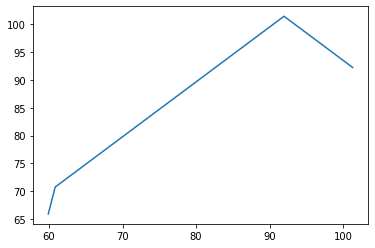

In [11]:

L=funcion_simuladora(100,100,0,100,1,1,10)#Genero 10 partículas
for n in L:#Comenzamos a iterar sobre la lista de partículas
  for j in range(15):
   
   n.paso_dt(0.1)
   if n.ver_colision_esquina(100,100):#vemos si colisionan o no con una esquina, si colisionan se resuelve la colisión
     n.resolver_colision_esquina
     #print("chcocó esquina")
   if n.ver_colision_muro(100,100):#vemos si colisionan o no con un muro, si colisionan se resuelve la colisión
     n.resolver_colision_muro(100,100)
     #print("chcocó muro")
   for p2 in L:
     if n.ver_colision_pp(p2) and (n.posicion!=p2.posicion).all():#vemos si colisionan o no con un muro, si colisionan se resuelve la colisión
       n.resolver_colision_particula(p2)                          #También se ve que la condición no haga resolver el choque de la partícula con ella
       #print("chocaron")                                         #misma

for n in range(10):#Acá vemos como se guarda cada trayectoria de cada partícula
 print(L[n].posicion_n)

x=[]
y=[]
for n in L[0].posicion_n:#graficamos la trayectoria de la primera partícula y vemos que los métodos de choque con otra partícula y con las paredes
  x.append(n[0])         #y esquinas funcionan.
  y.append(n[1])
plt.plot(x,y)
plt.show()
#plt.xlim((0,1000))
#plt.ylim((0,1000))
#En la parte de abajo del plot se ve que hay un cambio en la trayectoria, eso es porque la partícula chocó con otra

FUNCION DEFINITIVA

In [12]:
def funcion_simuladora_definitiva(lx,ly,v1,v2,m,r,n,dt,pasos):#El proceso anterior lo generalizamos en una función
  L=funcion_simuladora(lx,ly,v1,v2,m,r,n)
  for N in L:
    for i in range(pasos):
      N.paso_dt(dt)
      if N.ver_colision_esquina(lx,ly):
        N.resolver_colision_esquina
      if N.ver_colision_muro(lx,ly):
        N.resolver_colision_muro(lx,ly)
      for P in L:
        if N.ver_colision_pp(P) and (N.posicion!=P.posicion).all():
          N.resolver_colision_particula(P)
  return L
      

PRUEBA DE LA FUNCIÓN DEFINITIVA: Algo a tener en cuenta es que a la hora de extraer la información de las velcidades y posiciones a lo largo del tiempo, sí es útil que cada partícula tenga esa información, el código de la simulación no está tardando una cantidad exagerada de tiempo y me parece que es más facil manipular las cosas así.


In [13]:
A=funcion_simuladora_definitiva(100,100,0,100,1,1,10,0.01,15)
print(A[0].posicion_n)
print(A)

[array([85.85697937, 59.75247574]), array([86.72639517, 60.74763479]), array([87.59581097, 61.74279384]), array([88.46522676, 62.73795289]), array([89.33464256, 63.73311194]), array([90.20405836, 64.72827099]), array([91.07347416, 65.72343004]), array([91.94288995, 66.71858909]), array([92.81230575, 67.71374814]), array([93.68172155, 68.70890719]), array([94.55113735, 69.70406624]), array([95.42055315, 70.6992253 ]), array([96.28996894, 71.69438435]), array([97.15938474, 72.6895434 ]), array([98.02880054, 73.68470245]), array([98.89821634, 74.6798615 ])]
[<_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f29b16ce898>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f29b16ce6a0>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f29b16c97f0>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f29b16c9cc0>, <_cython_magic_23919ec3535f64540f628291a417670d.Particula object at 0x7f29b16ce390>, <_cython_magi

DATOS PARA PATER

In [ ]:
A=funcion_simuladora_definitiva(100,100,0,100,1,1,30,0.01,50)
print(A)
L=[]#Esta lista está formada por 30 sublistas que tienen el recorrido de la partículas, por alguna razón no me dejó separar esas sublistas
     #En una tupla de listas para x e y pero esto es lo que se tiene, si Pater puede mirar la forma de correrlo así le agradezco
for n in A:
  L.append(n.posicion_n)
print(L)

PRUEBA PARA MUCHAS PARTÍCULAS

In [ ]:
funcion_simuladora_definitiva(1000,1000,0,100,1,1,150,0.01,1500)#se demora entre 5 y 10 minutos (1500 pasos, con 150 partículas)